## Demo Notebook to show potential quicklooks

In [1]:
import sys
sys.path.insert(1, '..')
import warnings
from importlib import reload
import xarray as xr
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from functions import thermo as th
from functions import plotting as pf
reload(th)
reload(pf)

import metpy
import metpy.calc as mpcalc
from metpy.units import units

from pylab import shape,size
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import glob

import cartopy as cp
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import LAND
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates

from pandas import DataFrame
from sklearn import linear_model

# CAUTION: suppressing warnings here is only to keep this tutorial clean; not recommended for regular use
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
warnings.filterwarnings('ignore', 'This function will be removed in tqdm==5.0.0')
warnings.filterwarnings('ignore', 'Mean of empty slice')
warnings.filterwarnings('ignore', 'Degrees of freedom <= 0 for slice')

In [2]:
directory = '../extra/Sample_Data/20200122/'
allfiles = sorted(glob.glob(directory + '*QC.nc'))

ori_list = [None] * len(allfiles)
new_index = {'alt':np.arange(0,9100,10)}

g = 0
for i in tqdm(allfiles) :
    ori_list[g] = xr.open_dataset(i).dropna(dim='time',subset=['time']).isel(obs=0).\
                  swap_dims({'time':'alt'}).reset_coords().\
                  dropna(dim='alt',subset=['alt','pres','u_wind','v_wind','lat','lon','mr'],
                         how='any').\
                  interp(alt=np.arange(0,9100,10))
    g = g + 1

ds = xr.concat(ori_list[:],dim='launch_time')

ds['T'] = ds['tdry'] + 273.15

ds['q'] = (['launch_time','alt'],
            metpy.calc.specific_humidity_from_mixing_ratio(ds['mr']).data)

In [3]:
## Integrated Water Vapour

iwv = [None] * len(ds['launch_time'])
    
for i in tqdm(range(len(ds['launch_time']))) :

    iwv[i] = metpy.calc.precipitable_water(ds['pres'].isel(launch_time=i).values*units.mbar,
                                           ds['dp'].isel(launch_time=i).values*units.degC,).magnitude

ds['iwv'] = (['launch_time'],iwv)

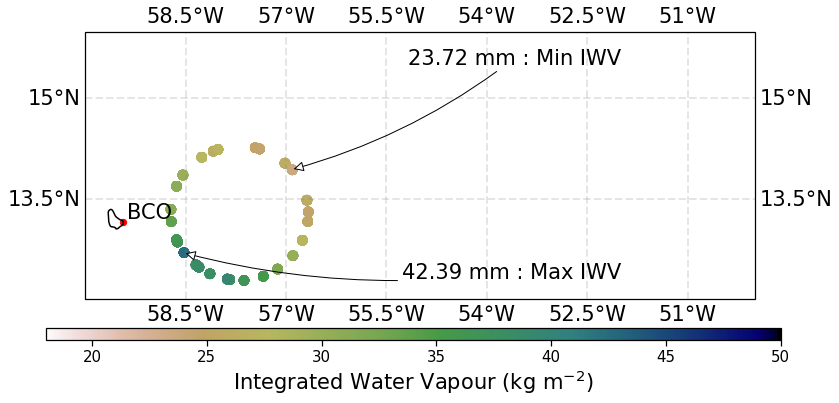

In [4]:
# Plotting a spatial variability of IWV

sb.set_context('notebook',font_scale=1.75)
fig = plt.figure(figsize = (12,8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1.5);

arr = ds['iwv']
lat_max = ds['lat'].isel(launch_time=np.where(arr == np.max(arr))[0]).isel(alt=-100)
lon_max = ds['lon'].isel(launch_time=np.where(arr == np.max(arr))[0]).isel(alt=-100)
lat_min = ds['lat'].isel(launch_time=np.where(arr == np.nanmin(arr))[0]).isel(alt=-800)
lon_min = ds['lon'].isel(launch_time=np.where(arr == np.nanmin(arr))[0]).isel(alt=-800)

for i in range(len(ds['launch_time'])) :
    im = ax.scatter(ds['lon'].isel(alt=-400), ds['lat'].isel(alt=-400),
                marker='o',s=90,transform=ccrs.PlateCarree(),c=iwv,cmap='gist_earth_r',vmin=18,vmax=50)

ax.annotate(str(round(ds['iwv'].isel(launch_time=np.where(arr == np.max(arr))[0]).values[0],2))
            +' mm : Max IWV', (lon_max,lat_max), xytext=(0.8, 0.1), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="-|>",connectionstyle="arc3,rad=-0.1",fc="w"),
            horizontalalignment='right', verticalalignment='center')

ax.annotate(str(round(ds['iwv'].isel(launch_time=np.where(arr == np.min(arr))[0]).values[0],2))
            +' mm : Min IWV', (lon_min,lat_min),xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="-|>",connectionstyle="arc3,rad=-0.1",fc="w"),
            horizontalalignment='right', verticalalignment='center')

bco_lat = 13.162; bco_lon = -59.428
ax.text(bco_lon+0.05,bco_lat+0.05,'BCO',c='k',transform=ccrs.PlateCarree())
ax.scatter(bco_lon,bco_lat,marker='o',s=40,c='r',transform=ccrs.PlateCarree())

# Defining boundaries of the plot
lon_w = -60; lon_e = -50; lat_s = 12; lat_n = 16

# Assigning axes ticks
xticks = np.arange(-180,180,1.5); yticks = np.arange(-90,90,1.5)

# Setting up the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--')
gl.xlocator = mticker.FixedLocator(xticks); gl.ylocator = mticker.FixedLocator(yticks)
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'k'}; gl.ylabel_style = {'color': 'k'}
gl.xlabel = {'Latitude'}

ax.set_extent([lon_w,lon_e,lat_s,lat_n])

cax=fig.add_axes([0.08,0.20,0.85,0.02])
g = plt.colorbar(im, cax=cax,
             orientation='horizontal',shrink=0.7,pad=.07)#,fraction=0.2)
g.set_label('Integrated Water Vapour (kg m$^{-2}$)')
plt.tick_params(labelsize=15)

Text(0, 0.5, 'Latitude / $\\degree$')

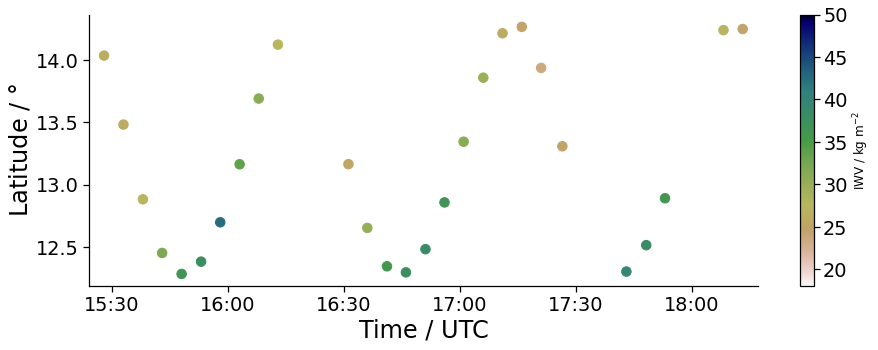

In [5]:
ax = plt.figure(figsize=(15,5))
plt.scatter(ds['launch_time'].values,ds['lat'].isel(alt=-400).values,s=90,
            c=ds['iwv'],vmin=18,vmax=50,cmap='gist_earth_r')
plt.xlim(np.min(ds['launch_time'].values) - np.timedelta64(4, 'm'),
        np.max(ds['launch_time'].values) + np.timedelta64(4, 'm'))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
g = plt.colorbar()
g.set_label('IWV / kg m$^{-2}$',fontsize=12)

myFmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlabel('Time / UTC',fontsize=24)
plt.ylabel('Latitude / $\degree$',fontsize=24)

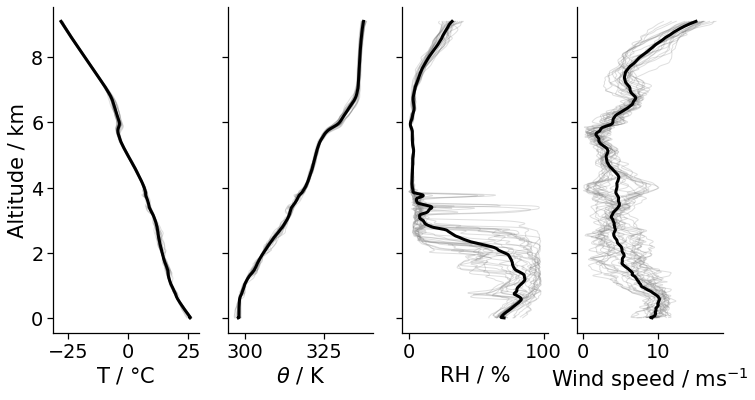

In [6]:
row = 1
col = 4

f,ax = plt.subplots(row,col,sharey=True,figsize=(12,6))

r = ['tdry','theta','rh','wspd','wdir']
r_titles = ['T / $\degree$C','$\\theta$ / K','RH / %','Wind speed / ms$^{-1}$','Wind direction / $\degree$']

for j in range(col) :
    d = ds[r[j]]
    for i in range(1,len(ds['launch_time'])-1) :
        ax[j].plot(d.isel(launch_time=i),
                ds['alt']/1000,
                   c='grey',alpha=0.25,linewidth=1)
        
    ax[j].plot(np.nanmean(d,axis=0),
               ds['alt']/1000,
                          linewidth=3,c='k')
    ax[j].set_xlabel(r_titles[j])
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    if j == 0 :
        ax[j].set_ylabel('Altitude / km')

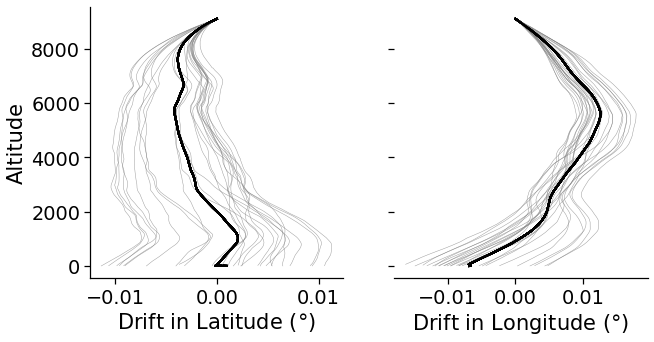

In [7]:
f,ax = plt.subplots(1,2,sharey=True,figsize=(10,5))

for i in range(len(ds['launch_time'])) :
    
    ax[0].plot(ds['lat'].isel(launch_time=i) - ds['lat'].isel(launch_time=i).isel(alt=-1),
             ds['alt'],linewidth=0.5,c='grey',alpha=0.75)
    ax[0].plot(np.mean(ds['lat'] - ds['lat'].isel(alt=-1),axis=0),
             ds['alt'],linewidth=2,c='k',alpha=1)
    ax[0].set_xlabel('Drift in Latitude ($\degree$)')
    ax[0].set_ylabel('Altitude')
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    
    ax[1].plot(ds['lon'].isel(launch_time=i) - ds['lon'].isel(launch_time=i).isel(alt=-1),
             ds['alt'],linewidth=0.5,c='grey',alpha=0.75)
    ax[1].plot(np.mean(ds['lon'] - ds['lon'].isel(alt=-1),axis=0),
             ds['alt'],linewidth=2,c='k',alpha=1)
    ax[1].set_xlabel('Drift in Longitude ($\degree$)')
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['left'].set_visible(False)

In [8]:
mse = th.calc_mse(ds['T'],ds['mr']/1000,ds['alt'])
mse_mean = np.nanmean(mse,axis=0)
mse_std = np.nanstd(mse,axis=0)

dse = th.calc_dse(ds['T'],ds['mr']/1000,ds['alt'])
dse_mean = np.nanmean(dse,axis=0)
dse_std = np.nanstd(dse,axis=0)

smse = th.calc_mse(ds['T'],th.q_sat(ds['T'],ds['pres']*100),ds['alt'])
smse_mean = np.nanmean(smse,axis=0)
smse_std = np.nanstd(smse,axis=0)

Text(0, 0.5, 'Altitude (km)')

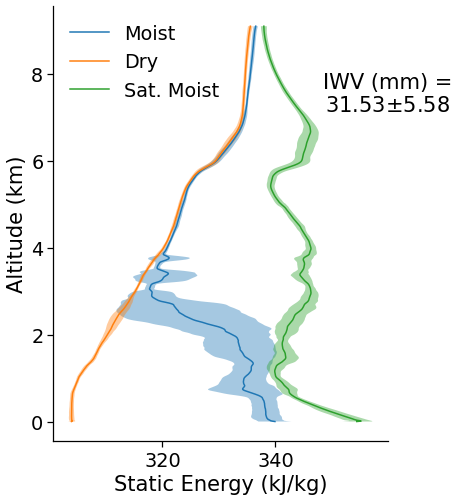

In [9]:
f = plt.figure(figsize=(6,8))

plt.plot(mse_mean/1000,ds['alt']/1000,label='Moist')
plt.fill_betweenx(ds['alt']/1000,
                 (mse_mean - mse_std)/1000,
                 (mse_mean + mse_std)/1000,
                 alpha=0.4)

plt.plot(dse_mean/1000,ds['alt']/1000,label='Dry')
plt.fill_betweenx(ds['alt']/1000,
                 (dse_mean - dse_std)/1000,
                 (dse_mean + dse_std)/1000,
                 alpha=0.4)

plt.plot(smse_mean/1000,ds['alt']/1000,label='Sat. Moist')
plt.fill_betweenx(ds['alt']/1000,
                 (smse_mean - smse_std)/1000,
                 (smse_mean + smse_std)/1000,
                 alpha=0.4)

plt.legend(frameon=False,loc=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.text(1,0.8,'IWV (mm) =\n' 
         + str(round(np.nanmean(iwv),2)) + '$\pm$'
         + str(round(np.std(iwv),2)), 
         horizontalalignment='center',
        verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Static Energy (kJ/kg)')
plt.ylabel('Altitude (km)')

# More ideas / opinions / wishes for Quicklooks? 
# Maybe some synergy quicklooks?